In [48]:
%matplotlib inline

import copy
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from tqdm import tqdm
from geopandas import GeoDataFrame
from geopandas.plotting import plot_polygon_collection
from shapely.geometry import shape, mapping, Point

# Import data

In [49]:
# Define dataset
dataset = "commuter"

In [50]:
# Cost matrix
cost_matrix = np.loadtxt('../data/input/{}/cost_matrix.txt'.format(dataset))
# Origin supply
origin_supply = np.loadtxt('../data/input/{}/origin_supply.txt'.format(dataset))
# Destination demand
destination_demand = np.loadtxt('../data/input/{}/destination_demand.txt'.format(dataset))
# Origin-destination matrix for validation
od_matrix = np.loadtxt('../data/input/{}/od_matrix.txt'.format(dataset))

# Borough names
boroughs = np.loadtxt('../data/input/{}/origins-destinations.txt'.format(dataset),dtype=str)
# Borough polygons
borough_polygons = gpd.read_file('../data/input/{}/borough_coordinates.json'.format(dataset))
# Inferred flows through C function
newton_raphson_flows = np.loadtxt('../data/output/{}/newton_raphson_flows.txt'.format(dataset))

In [4]:
# Store total flow \sum_{i=1}^N \sum_{j=1}^M T_{ij}
total_flow = np.sum(origin_supply) # or equivalently np.sum(destination_demand)

In [5]:
# Select first num_zones zones
num_zones = cost_matrix.shape[0]

# Take subset of data
cost_matrix = cost_matrix[:num_zones,:num_zones]
od_matrix = od_matrix[:num_zones,:num_zones]
origin_supply = origin_supply[:num_zones]
destination_demand = destination_demand[:num_zones]

N,M = cost_matrix.shape

# Infer flows, i.e. origin-destination matrix

In [6]:
# Flags for print statements below
show_params = False
show_flows = True

# Set parameters
_beta = -13.78532656
_intercept = 1.0
A_initial = 1.0
B_initial = 1.0

# Set maximum_iterations
max_iterations = 100#int(1e4)

# Initialise list of parameters
parameters = {'beta':_beta,'intercept':_intercept,'A_initial':A_initial,'B_initial':B_initial}

In [7]:
# def flow_inference(orig_supply:np.array,dest_demand:np.array,cost_mat:np.array,params:dict,max_iters:int=1000,show_params:bool=False,show_flows:bool=False):    
#     '''
#     orig_supply [array]: supply generated at each origin zone 
#     dest_demand [array]: demand generated at each destination zone
#     cost_mat [array]: matrix of costs travelling from each origin to each destination
#     show_params [boolean]: flag for printing parameter matrices A and B
#     show_flows [boolean]: flag for printing flow from each origin to each destination
#     max_iters [int]: maximum iterations for which system of equations should be solved
#     '''
#     # Note that
#     # A_i = \exp(-lambda_i)/O_i
#     # B_j = \exp(-kappa_j)/D_j

    
#     # Get dimensions of cost matrix
#     N,M = cost_mat.shape
    
#     # Unpack parameters
#     beta = params['beta']
#     intercept = params['intercept']
#     A = np.ones(N) * params['A_initial']
#     B = np.ones(M) * params['B_initial']
    
#     # Initialise empty flow matrix
#     flows = np.zeros((N,M))
    
#     for n in tqdm(range(N)):
#         for m in range(M):
#             # Solve normalising factors iteratively
#             t = 0
#             while (t < max_iters - 1):
#                 # Use initial values of lambda and kappa parameters
                
#                 # Update $A_i$
#                 # $A_i = 1 / \sum_{p=0}^M B_j D_j \exp(-\beta c_{pj})$
#                 temp = 0
#                 for mm in range(M):
#                     temp += B[mm] * dest_demand[mm] * np.exp(-beta*cost_mat[n,mm])
#                 A[n] = 1. / temp

#                 # Update $B_j$
#                 # $B_j = 1 / \sum_{l=0}^N A_i O_i \exp(-\beta c_{lj})$
#                 temp = 0
#                 for nn in range(N):
#                     temp += A[nn] * orig_supply[nn] * np.exp(-beta*cost_mat[nn,m])
#                 B[m] = 1. / temp

#                 # Increment number of iterations
#                 t += 1

#             # Print statement
#             if show_params:
#                 print('A',A[n])
#                 print('B',B[m])
            
#             # Add solution for flows: $T_{ij} = A_i B_j O_i D_j \exp(-\beta c_{ij})$
#             flows[n,m] = int(_intercept*A[n]*B[m]*orig_supply[n]*dest_demand[m]*np.exp(-beta*cost_mat[n,m]))

#             # Print statement
#             if show_flows:
#                 print('Flow',flows[n,m])

#     return flows

In [8]:
# python_inferred_flows = flow_inference(origin_supply,destination_demand,cost_matrix,parameters,max_iterations)

In [9]:
# # Get total inferred supply and demand for origins and destinations, respectively
# inferred_supply = np.sum(python_inferred_flows,axis=1)
# inferred_demand = np.sum(python_inferred_flows,axis=0)

In [10]:
# print('Origin supply inferred',inferred_supply)
# print('Destination demand inferred',inferred_demand)

In [11]:
# print('Total flow inferred',np.sum(inferred_demand))
# print('Total flow actual',np.sum(destination_demand))

In [13]:
# # Compute error
# square_error = 0
# for i in range(N):
#     for j in range(M):
#         square_error += (python_inferred_flows[i,j] - od_matrix[i,j])**2
# print("RMSE", math.sqrt(square_error/(N*M)))

# Learn parameters using PySal

In [14]:
import pysal

## Import data as dataframe

In [15]:
# Cost matrix
cost_matrix_df = pd.read_csv('../data/input/{}/cost_matrix.csv'.format(dataset),index_col=0)
# Origin supply
origin_supply_df = pd.read_csv('../data/input/{}/origin_supply.csv'.format(dataset),index_col=0)
# Destination demand
destination_demand_df = pd.read_csv('../data/input/{}/destination_demand.csv'.format(dataset),index_col=0)
# Origin-destination matrix for validation
od_matrix_df = pd.read_csv('../data/input/{}/od_matrix.csv'.format(dataset),index_col=0)

## Reshape data

In [16]:
od_data = pd.DataFrame(columns=['Origin','Destination','Cost','Flow','OriginSupply','DestinationDemand'])

In [17]:
# Loop over origins and destinations
for orig in tqdm(cost_matrix_df.columns):
    for dest in cost_matrix_df.columns:
        # Add row properties
        new_row = pd.Series({"Origin": orig, 
                             "Destination": dest, 
                             "Cost": cost_matrix_df.loc[orig,dest],
                             "Flow": od_matrix_df.loc[orig,dest],
                             "OriginSupply": origin_supply_df.loc[orig,'Supply'],
                             "DestinationDemand":destination_demand_df.loc[dest,'Demand']})
        # Append row to dataframe
        od_data = od_data.append(new_row, ignore_index=True)

100%|██████████| 33/33 [00:06<00:00,  5.48it/s]


In [18]:
flows_flat = od_data.Flow.values.astype('int64') 
orig_supply_flat = od_data.OriginSupply.values.astype('int64')
dest_demand_flat = od_data.DestinationDemand.values.astype('int64')
cost_flat = od_data.Cost.values.astype('float64')

In [19]:
doubly = pysal.model.spint.Doubly(flows_flat, orig_supply_flat, dest_demand_flat, cost_flat, 'exp')

In [20]:
# Print optimised parameter
'distance coefficient',doubly.params[-1:][0]

('distance coefficient', -13.785326563646777)

In [21]:
'intercept',doubly.params[0]

('intercept', 6.650276665877912)

### Reconstruct predicted flows

In [22]:
pysal_flows = np.zeros((N,M))
for i in tqdm(range(N)):
    for j in range(M):
        pysal_flows[i][j] = doubly.yhat[i*M + j]

100%|██████████| 33/33 [00:00<00:00, 4691.46it/s]


In [23]:
print('Pysal total flows',np.sum(pysal_flows))
print('Actual total flows',np.sum(od_matrix))

Pysal total flows 2796999.000263002
Actual total flows 2796999.0


In [24]:
# pd.DataFrame(pysal_flows)

# Compare inferred flows with actual

In [51]:
print('Actual total flow:',np.sum(od_matrix))
print('PySAL inferred total flow:',np.sum(pysal_flows))
print('Newton Raphson (C function) inferred total flow:',np.sum(newton_raphson_flows))

Actual total flow: 2796999.0
PySAL inferred total flow: 2796999.000263002
Newton Raphson (C function) inferred total flow: 2796461.0


In [52]:
print('Actual total supply:',np.sum(od_matrix,axis=1))
print('PySAL total supply:',np.sum(pysal_flows,axis=1))
print('Newton Raphson (C function) total supply:',np.sum(newton_raphson_flows,axis=1))

Actual total supply: [ 57657. 118436.  84912. 101383. 118739.  78187.   3689. 129572. 120845.
 101325.  79805.  69782.  71927.  83316.  77669.  85381.  92299.  82957.
  70337.  61957.  57336. 116105. 101953.  80066.  75928.  89671.  69403.
  95799.  70449.  65213.  85876. 123389.  75636.]
PySAL total supply: [ 57656.99999999 118436.00000004  84911.99999994 101382.99999981
 118739.00000029  78186.99999989   3689.00026249 129572.00000011
 120844.99999996 101325.00000018  79805.00000034  69782.00000024
  71927.00000027  83315.99999999  77668.99999974  85380.99999988
  92298.99999979  82956.99999994  70337.00000019  61957.00000015
  57336.00000007 116105.00000034 101953.00000012  80065.99999943
  75927.99999979  89670.99999978  69402.99999986  95799.00000015
  70448.99999983  65213.00000017  85875.99999955 123389.00000029
  75636.00000038]
Newton Raphson (C function) total supply: [ 57645. 118420.  84894. 101368. 118726.  78171.   3674. 129555. 120827.
 101310.  79787.  69765.  71910.  832

In [53]:
print('Actual total demand:',np.sum(od_matrix,axis=0))
print('PySAL total demand:',np.sum(pysal_flows,axis=0))
print('Newton Raphson (C function) total demand:',np.sum(newton_raphson_flows,axis=0))

Actual total demand: [ 38747.  74789.  45421.  68322.  76223. 174520. 211588.  96120.  83997.
  62826.  51039.  56775.  79612.  48207.  46107.  53035. 103596.  73846.
 106333.  80001.  43692.  88079.  51183.  49149.  52103.  49699.  47304.
 107899.  47466. 116374.  45997.  77197. 389753.]
PySAL total demand: [ 38747.00000005  74789.00000135  45421.00000007  68322.00000049
  76223.0000006  174520.00001376 211588.00014007  96120.00000129
  83997.00000017  62826.00000161  51039.00000045  56775.0000072
  79612.00000157  48207.00000321  46107.00000004  53034.99999998
 103595.99999995  73846.00000008 106333.00001999  80001.00000281
  43692.00000018  88079.00000658  51183.00000151  49149.0000006
  52103.0000006   49699.00000018  47304.00000015 107899.00001406
  47466.0000004  116374.00001004  45997.00000099  77197.00000195
 389753.00003101]
Newton Raphson (C function) total demand: [ 38731.  74773.  45406.  68306.  76210. 174504. 211571.  96107.  83982.
  62808.  51023.  56762.  79599.  48192

# Visualise actual and inferred O/D matrices

In [28]:
# Actual flows: od_matrix -- name: actual_flows
# PySal flows: pysal_flows -- name: pysal_flows
# Newton Raphson (C) algorithm's flows: newton_raphson_flows -- name: Newton_raphson_flows

# Choose filename
filename = "pysal_flows"

# Decide which data to visualise
if "actual" in filename:
    # Decide which data to plot
    heatmap_data = od_matrix.astype(int)
elif "pysal" in filename:
    # Decide which data to plot
    heatmap_data = pysal_flows.astype(int)
elif "newton_raphson" in filename:
    # Decide which data to plot
    heatmap_data = newton_raphson_flows.astype(int)    

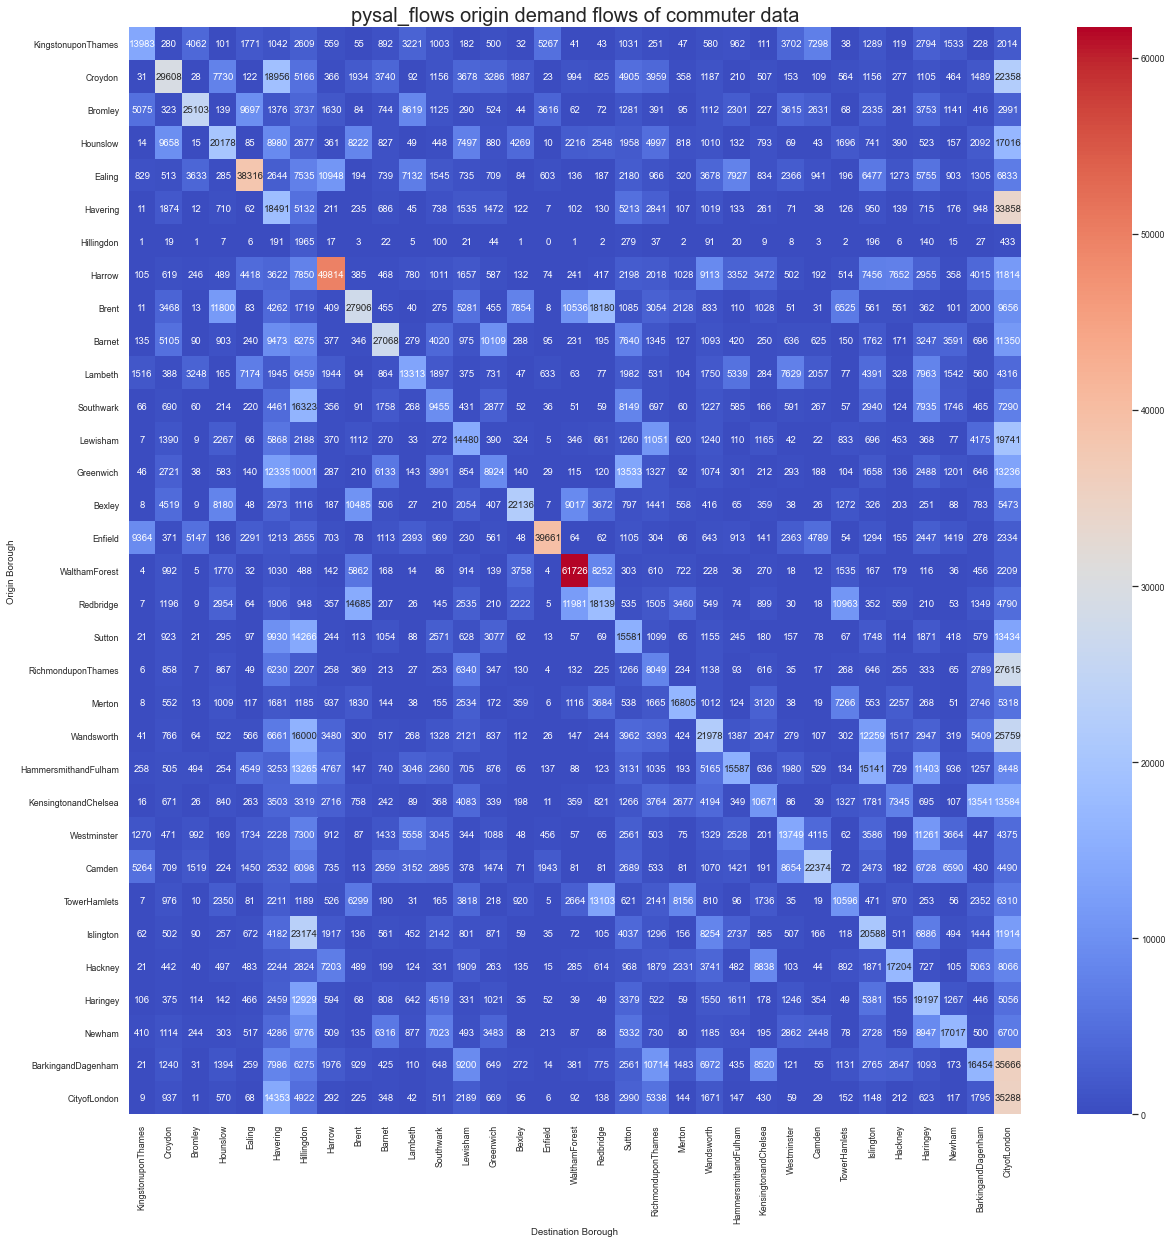

In [29]:
# Change font scaling
sns.set(font_scale=0.8)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(heatmap_data,
                            annot=True,
                            cmap="coolwarm",
                            fmt="d",
                            xticklabels=boroughs,
                            yticklabels=boroughs)
# Add x,y axes labels
plt.xlabel("Destination Borough")
plt.ylabel("Origin Borough")
# Add title
plt.title('{} origin demand flows of {} data'.format(filename,dataset), fontsize=20)

# Save figure to output
plt.savefig('../data/output/{}/figures/{}.png'.format(dataset,filename))

# Visualise cost matrix

In [30]:
# # Change font scaling
# sns.set(font_scale=0.8)
# # Set plot size
# plt.figure(figsize=(20,20))
# # Add heatmap
# cost_matrix_heatmap = sns.heatmap(cost_matrix,
#                             annot=True,
#                             cmap="coolwarm",
#                             xticklabels=boroughs,
#                             yticklabels=boroughs,
#                             linewidths=.05)
# # Add x,y axes labels
# plt.xlabel("Destination Borough")
# plt.ylabel("Origin Borough")
# # Add title
# plt.title('Cost matrix of {} data'.format(dataset), fontsize=20)

# # Save figure to output
# plt.savefig('../data/output/{}/figures/cost_matrix.png'.format(dataset))

# Visualise origin and destination demand

In [31]:
borough_polygons.loc[:,'pysal_origin_supply'] = np.sum(pysal_flows,axis=1)
borough_polygons.loc[:,'pysal_destination_demand'] = np.sum(pysal_flows,axis=0)
borough_polygons.loc[:,'actual_origin_supply'] = np.sum(od_matrix,axis=1)
borough_polygons.loc[:,'actual_destination_demand'] = np.sum(od_matrix,axis=0)
borough_polygons.loc[:,'destination_demand_pysal_error'] = np.sum(od_matrix,axis=0) - np.sum(pysal_flows,axis=0)
borough_polygons.loc[:,'origin_supply_pysal_error'] = np.sum(od_matrix,axis=1) - np.sum(pysal_flows,axis=1)

In [32]:
# Choose variable to plot
var = 'origin_supply_pysal_error'
colormap = 'YlOrRd_r'#'winter'

In [43]:
ax=None

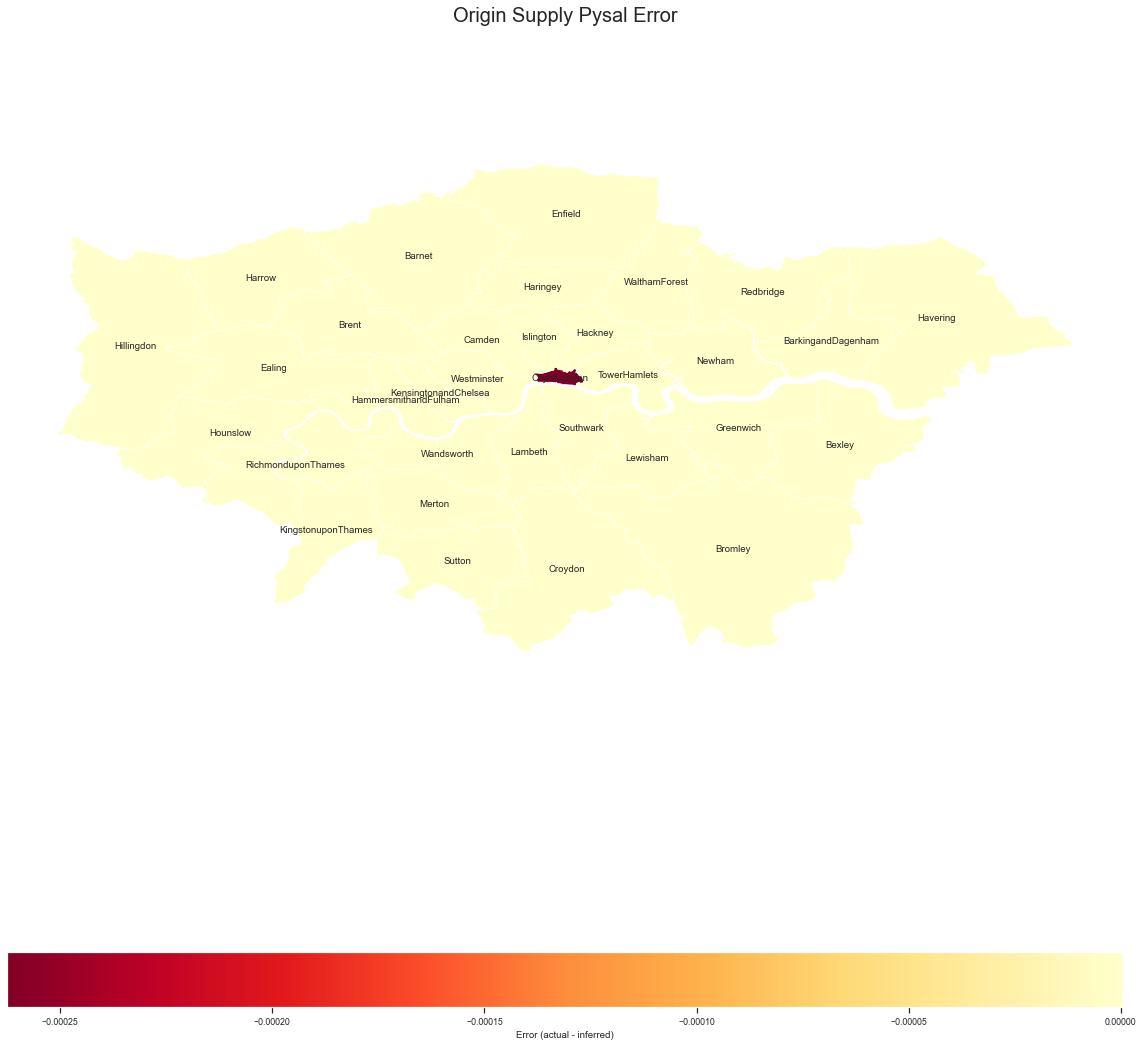

In [47]:
borough_polygons.plot(figsize=(20,20),
                      linewidth=0.5,
                      column=var,
                      cmap=colormap, 
                      legend=True,
                      vmin=min(borough_polygons[var]), 
                      vmax=max(borough_polygons[var]),
                      legend_kwds={'label': "Error (actual - inferred)",
                                   'orientation': "horizontal"})

for index, row in borough_polygons.iterrows():
    xy = row['geometry'].centroid.coords[:]
    xytext = row['geometry'].centroid.coords[:]
    plt.annotate(row['name'], xy=xy[0], xytext=xytext[0], horizontalalignment='center', verticalalignment='center')
    plt.axis('off')
# Add new axes manually and change their font size
# cax = fig.add_axes([1, 0.1, 0.03, 0.8])
# sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min(borough_polygons[var]), 
#                                                              vmax=max(borough_polygons[var])))
# sm._A = []
# cbr = fig.colorbar(sm, cax=cax,)
# cbr.ax.tick_params(labelsize=18) 

# # Produce tight layout
# ax.margins(0)
# ax.apply_aspect()
# bbox = ax.get_window_extent().inverse_transformed(fig.transFigure)
# w,h = fig.get_size_inches()
# fig.set_size_inches(w*bbox.width, h*bbox.height)

cmap = cm.get_cmap('Blues')
white_patch = mpatches.Patch(color=cmap(0.0), label='0 - 5')
lowblue_patch = mpatches.Patch(color=cmap(0.25), label='5 - 10')
midblue_patch = mpatches.Patch(color=cmap(0.5), label='10 - 14')
highblue_patch = mpatches.Patch(color=cmap(0.75), label='14 - 19')
veryblue_patch = mpatches.Patch(color=cmap(1.0), label='19 - 24')
plt.legend(handles=[white_patch, lowblue_patch, midblue_patch, highblue_patch, veryblue_patch])


plt.savefig('../data/output/{}/figures/{}.png'.format(dataset,var))
plt.show()

# Compute validation metrics

## PySAL method comparison with true baseline

In [ ]:
sum_absolute_error = 0
for i in tqdm(range(N)):
    for j in range(M):
        sum_absolute_error += abs(od_matrix[i][j] - pysal_flows[i][j])
print('Mean absolute error', sum_absolute_error/(N*M))